In [1]:
# Prepares iPython notebook for working with matplotlib
%matplotlib inline 

import numpy as np # imports a fast numerical programming library
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes

#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.options.mode.chained_assignment = None
from matplotlib import rc
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

rc('font', **font)

import seaborn as sns #sets up styles and gives us more plotting options
sns.set()

In [2]:
from datetime import datetime

def addseason(datestring):
    item = datetime.strptime(datestring,"%Y-%m-%d %H:%M:%S")
    if 2 < item.month < 6:
        return 'spring' # spring
    elif 5 < item.month < 9:
        return 'summer' # summer
    elif 8 < item.month < 12:
        return 'autumn' # autumn
    else:
        return 'winter' # winter

def addmonth(datestring):
    item = datetime.strptime(datestring,"%Y-%m-%d %H:%M:%S")
    year = {1:'january', 2:'february', 3:'march', 4:'april',
            5:'may', 6:'june', 7:'july', 8:'august', 9:'september',
            10: 'october', 11: 'november', 12: 'december'}
    return year[item.month]
    
def addseconds(datestring):
    t = datetime.strptime(datestring,"%Y-%m-%d %H:%M:%S")
    return (t - datetime(2017,1,1)).total_seconds()

def addsecondstolvl(datestring):
    datestring = datestring[0:-4]
    t = datetime.strptime(datestring,"%d/%m/%Y %H:%M:%S")
    return (t - datetime(2017,1,1)).total_seconds()

def addband(longitude):
    if 6.95 < longitude < 7:
        return 1
    else:
        return 0

def addphase(seconds):
    period = (12 * 60 * 60) + (25.2 * 60) 
    half_period = period / 2
    startphase = (half_period / 12) * 8
    modulus = (seconds - startphase) % period
    if modulus < half_period:
        return 'low'
    else:
        return 'high'

def addphase_2(slev):
    if slev > 0:
        return 'high'
    else:
        return 'low'
    
def commafix(string):
    return float(string.replace(',','.'))

def calculateTA(method,t,s):
    if method == 'Bellerby':
        if s >= 34.65:
            return 66.96 * s - 36.803 # Bellerby & Canoba
        else:
            return 3887 - 46.25 * s # Borges & Frankignoulle & Canoba
    elif method == 'Millero':
        if t < 20:
            return s / 35 * (2291 - 2.69 * (t - 20) - 0.046 * np.square(t - 20)) # Millero et al, MarChem, 1998
        else:
            return 520.1 + 51.24 * s # Millero et al, MarChem, 1998

In [3]:
def treatlvl(sealvldata):
    sealvldata['Seconds_since_start_of_the_year'] = sealvldata.TIME.map(addsecondstolvl)
    try:
        sealvldata['SLEV'] = sealvldata.SLEV.map(commafix)
    except AttributeError:
        pass
    sealvldata = sealvldata[sealvldata.SLEV.values[:] != -999]
    sealvldata['Phase'] = sealvldata.SLEV.map(addphase_2)
    return sealvldata

In [4]:
def treatbiogeodata(biogeodata):
    biogeodata['Season'] = biogeodata.Datetime.map(addseason)
    biogeodata['Month'] = biogeodata.Datetime.map(addmonth)
    biogeodata['Seconds_since_start_of_the_year'] = biogeodata.Datetime.map(addseconds)
    biogeodata['TAfromS'] = [calculateTA('Millero',t, s) for t, s in zip(biogeodata.Temperature.values,
                                                                          biogeodata.Salinity.values)]
    # biogeodata['Band'] = biogeodata.Longitude.map(addband)
    return biogeodata

def addlvlphase(biogeodata, sealvldata):
    """biogeodata and sealvldata for the current month"""
    biogeodata['SLEV'] = [np.interp(x, sealvldata.Seconds_since_start_of_the_year.values, sealvldata.SLEV.values)
                          for x in biogeodata.Seconds_since_start_of_the_year.values]
    biogeodata['Phase'] = biogeodata.SLEV.map(addphase_2)
    return biogeodata

## Choose the sea level monthly file

In [5]:
sealvl_april = pd.read_csv('NO_201704_TS_MO_HelgolandTG.csv', sep=';', skiprows=52)
sealvl_may = pd.read_csv('NO_201705_TS_MO_HelgolandTG.csv', sep=';', skiprows=52)
sealvl_june = pd.read_csv('NO_201706_TS_MO_HelgolandTG.csv', sep=';', skiprows=52)
sealvl_august = pd.read_csv('NO_201708_TS_MO_HelgolandTG.csv', sep=';', skiprows=52)

In [6]:
sealvl_april.head()

,TIME,DEPTH,LATITUDE,LONGITUDE,POSITION_QC,SLEV,SLEV_QC,TIME_QC
0,01/04/2017 00:00:00:000,0,"54,1789016723633","7,8899998664856",1.0,1,1,1
1,01/04/2017 00:10:00:000,0,NaN,NaN,NaN,"1,07000005245209",1,1
2,01/04/2017 00:20:00:000,0,NaN,NaN,NaN,"1,12999999523163",1,1
3,01/04/2017 00:30:00:000,0,NaN,NaN,NaN,"1,17999994754791",1,1
4,01/04/2017 00:40:00:000,0,NaN,NaN,NaN,"1,21000003814697",1,1


In [7]:

sealvl_april = treatlvl(sealvl_april)
sealvl_may = treatlvl(sealvl_may)
sealvl_june = treatlvl(sealvl_june)
sealvl_august = treatlvl(sealvl_august)

In [8]:
sealvl_april.head()

,TIME,DEPTH,LATITUDE,LONGITUDE,POSITION_QC,SLEV,SLEV_QC,TIME_QC,Seconds_since_start_of_the_year,Phase
0,01/04/2017 00:00:00:000,0,"54,1789016723633","7,8899998664856",1.0,1.00,1,1,7776000.0,high
1,01/04/2017 00:10:00:000,0,NaN,NaN,NaN,1.07,1,1,7776600.0,high
2,01/04/2017 00:20:00:000,0,NaN,NaN,NaN,1.13,1,1,7777200.0,high
3,01/04/2017 00:30:00:000,0,NaN,NaN,NaN,1.18,1,1,7777800.0,high
4,01/04/2017 00:40:00:000,0,NaN,NaN,NaN,1.21,1,1,7778400.0,high


## Choose the biogeodata yearly file

In [9]:
north7 = pd.read_csv("HafniaDataNorth7Shamil.csv")
south7 = pd.read_csv("HafniaDataSouth7Shamil.csv")
north7 = treatbiogeodata(north7)
south7 = treatbiogeodata(south7)

## Choose month and track

In [10]:
april_north = north7.groupby('Month').get_group('april')
april_south = south7.groupby('Month').get_group('april')
may_north = north7.groupby('Month').get_group('may')
june_south = south7.groupby('Month').get_group('june')
august_north = north7.groupby('Month').get_group('august')
august_south = south7.groupby('Month').get_group('august')

## Add sea level and tidal phase to data

In [11]:
april_north = addlvlphase(april_north,sealvl_april)
april_south = addlvlphase(april_south,sealvl_april)
may_north = addlvlphase(may_north,sealvl_may)
june_south = addlvlphase(june_south,sealvl_june)
august_north = addlvlphase(august_north,sealvl_august)
august_south = addlvlphase(august_south,sealvl_august)

## Plot sea level for the chosen month

In [12]:
def plotsealvl(sealvldata):

    fig, ax = plt.subplots(figsize=(10,5))

    for phase, subset in sealvldata.groupby('Phase'):
        Time = subset.Seconds_since_start_of_the_year.values / 60 / 60 / 24
        SLEV = subset.SLEV.values
        ax.scatter(Time, SLEV, label=phase)

    ax.legend()
    plt.xlabel("Days")
    plt.ylabel("Sea level")

## Plot yearly Alkalinity

In [13]:
def plotyearly():
    fig, ax = plt.subplots(figsize=(10,5),dpi = 100)
    Timenorth = north7.Seconds_since_start_of_the_year.values / 86400
    Timesouth = south7.Seconds_since_start_of_the_year.values / 86400
    TAnorth = north7.TA.values
    TAsouth = south7.TA.values
    ax.scatter(Timenorth, TAnorth, label='North')
    ax.scatter(Timesouth, TAsouth, label='South')
    ax.legend()
    plt.xlabel("Days")
    plt.ylabel("TA")

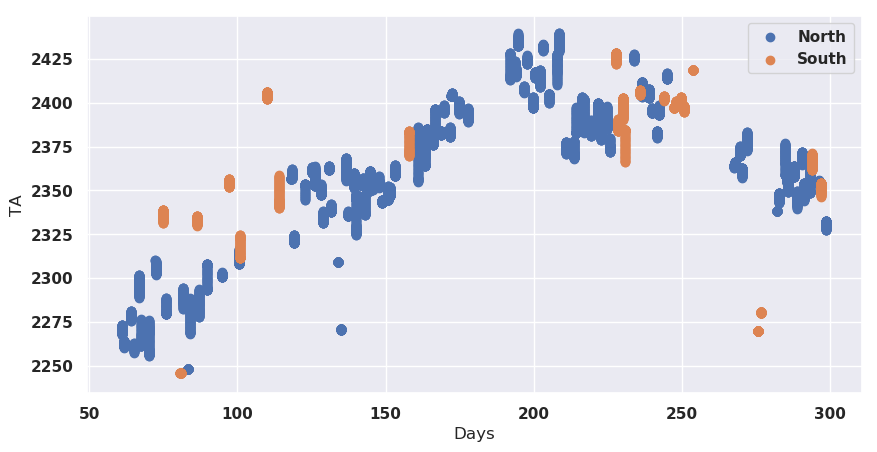

In [14]:
plotyearly()

In [15]:
def plotTA(biogeodata):
    fig, ax = plt.subplots(figsize=(12,5))
    Time = biogeodata.Seconds_since_start_of_the_year.values / 86400
    TA = biogeodata.TA.values
    TAfromS = biogeodata.TAfromS.values
    size = 14
    ax.scatter(Time, TA, label= 'Total Alkalinity Measured',s=size)
    ax.scatter(Time, TAfromS,
               label='\nTotal Alkalinity \nCalculated from salinity \nMillero et al, \nMarChem, 1998',s=size)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    ax.legend(fontsize = 14,loc = 'upper left')
    plt.xlabel("Day in a year")
    plt.ylabel('Total Alkalinity, $ \mu M$')
    

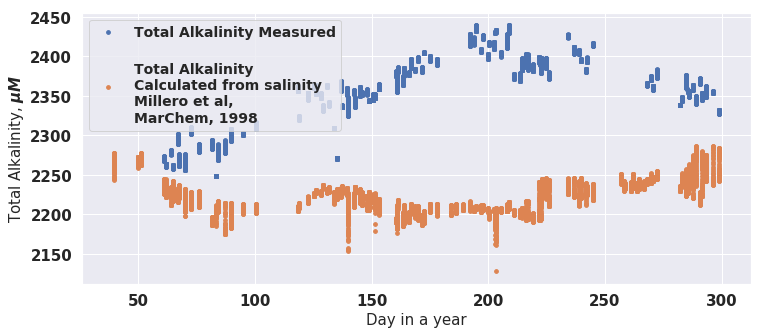

In [16]:
fig = plotTA(north7)
plt.savefig('fig.png',transparent = True)

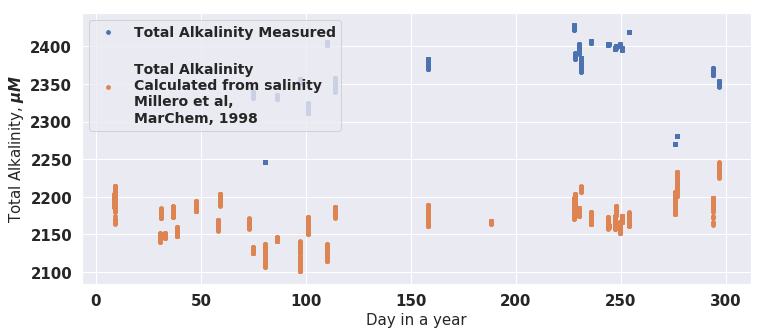

In [17]:
plotTA(south7)

In [18]:
def plotTAandS(biogeodata):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,5))
    Time = biogeodata.Seconds_since_start_of_the_year.values / 86400
    TA = biogeodata.TA.values
    S = biogeodata.Salinity.values
    ax1.scatter(Time, TA, label=biogeodata.TA.name)
    ax2.scatter(Time, S, label=biogeodata.Salinity.name)
    ax1.legend()
    ax1.set_xlabel("Days")
    ax1.set_ylabel("TA")
    ax2.legend()
    ax2.set_xlabel("Days")
    ax2.set_ylabel("S")

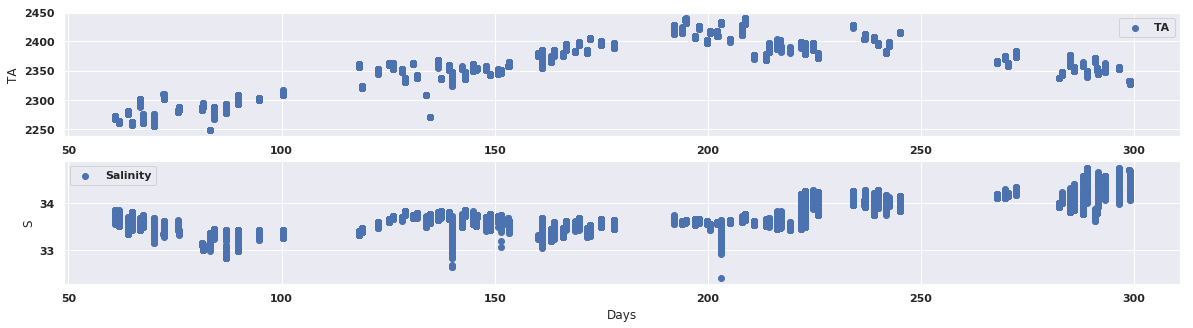

In [19]:
plotTAandS(north7[north7.TA.notnull()])

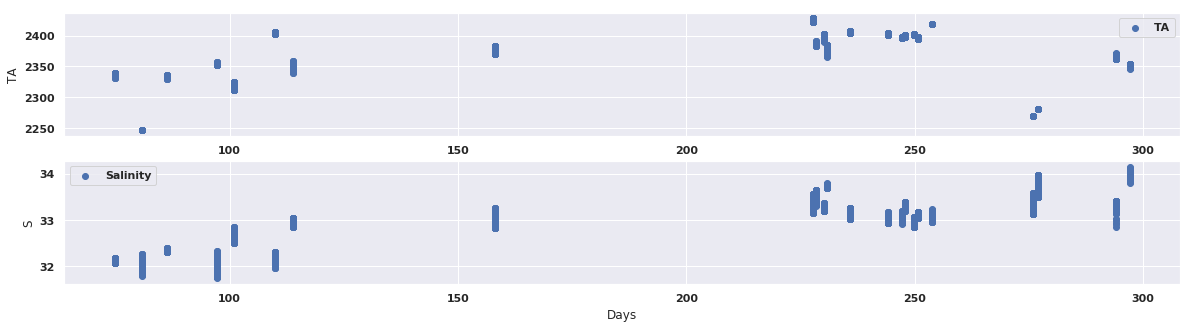

In [20]:
plotTAandS(south7[south7.TA.notnull()])

In [21]:
north7filtered = north7[north7.TA.notnull()]
south7filtered = south7[south7.TA.notnull()]

In [22]:
north7filtered['TA'].corr(north7filtered['Salinity'])

0.21814551875393406

In [23]:
south7filtered['TA'].corr(south7filtered['Salinity'])

0.14462938895912686

In [24]:
north7filtered['TAfromS'].corr(north7filtered['Salinity'])

0.902866770120433

In [25]:
south7filtered['TAfromS'].corr(south7filtered['Salinity'])

0.9756707169399699

## Plot Alkalinity divided by a seasons

In [26]:
def plotalkseasons(biogeodata):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    for season, subset in biogeodata.groupby('Season'):
        Long = subset.Longitude.values
        Lat = subset.Latitude.values
        TA = subset.TA.values
        ax1.scatter(Long, TA, label=season)
        ax2.scatter(Lat, TA, label=season)

    ax1.legend()
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Alk')
    ax2.legend()
    ax2.set_xlabel('Latitude')
    ax1.set_ylabel('Alk')

In [27]:
def plotsseasons(biogeodata):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    for season, subset in biogeodata.groupby('Season'):
        Long = subset.Longitude.values
        Lat = subset.Latitude.values
        S = subset.Salinity.values
        ax1.scatter(Long, S, label=season)
        ax2.scatter(Lat, S, label=season)

    ax1.legend()
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('S')
    ax2.legend()
    ax2.set_xlabel('Latitude')
    ax1.set_ylabel('S')

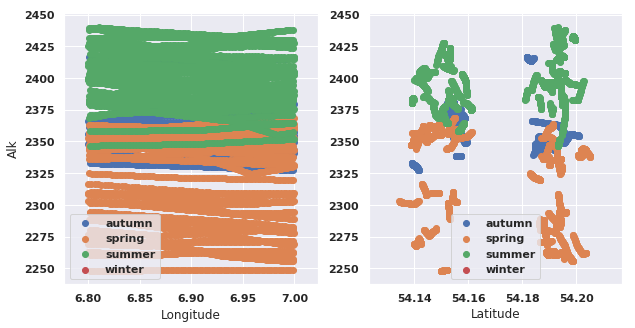

In [28]:
plotalkseasons(north7)

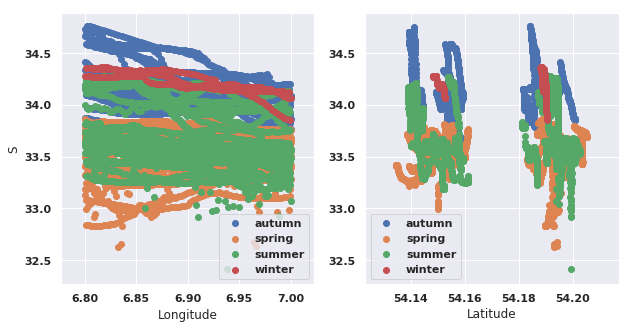

In [29]:
plotsseasons(north7)

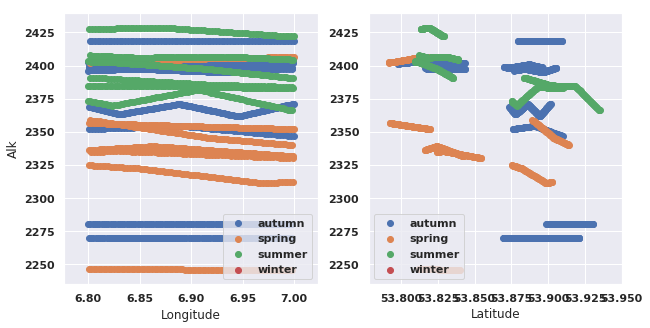

In [30]:
plotalkseasons(south7)

## Plot Alkalinity for the chosen month separeted by a tidal phase

In [31]:
def plotalkmonthtide(month):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    for phase, subset in month.groupby('Phase'):
        Long = subset.Longitude.values
        Lat = subset.Latitude.values
        TA = subset.TA.values
        ax1.scatter(Long, TA, label=phase)
        ax2.scatter(Lat, TA, label=phase)

    ax1.legend()
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Alk')
    ax2.legend()
    ax2.set_xlabel('Latitude')
    ax1.set_ylabel('Alk')

In [32]:
def plotsmonthtide(month):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    for phase, subset in month.groupby('Phase'):
        Long = subset.Longitude.values
        Lat = subset.Latitude.values
        S = subset.Salinity.values
        ax1.scatter(Long, S, label=phase)
        ax2.scatter(Lat, S, label=phase)

    ax1.legend()
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('S')
    ax2.legend()
    ax2.set_xlabel('Latitude')
    ax1.set_ylabel('S')

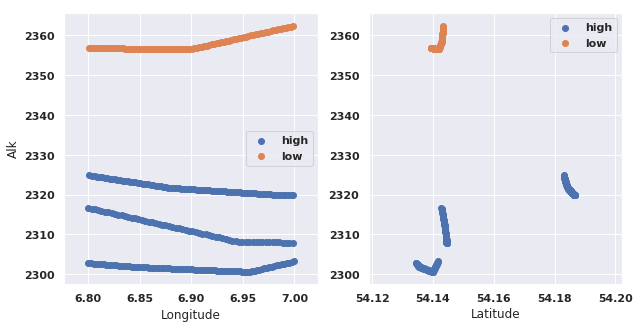

In [33]:
plotalkmonthtide(april_north)

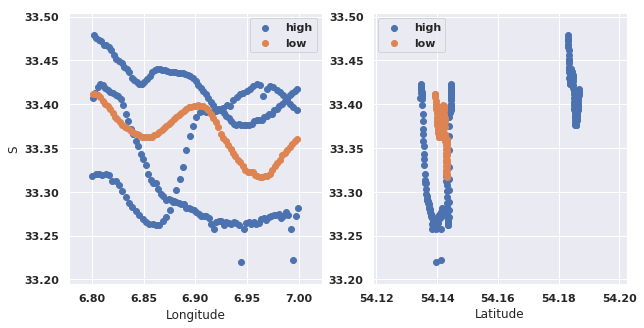

In [34]:
plotsmonthtide(april_north)

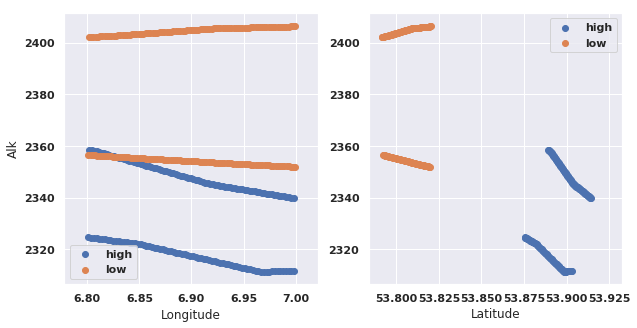

In [35]:
plotalkmonthtide(april_south)

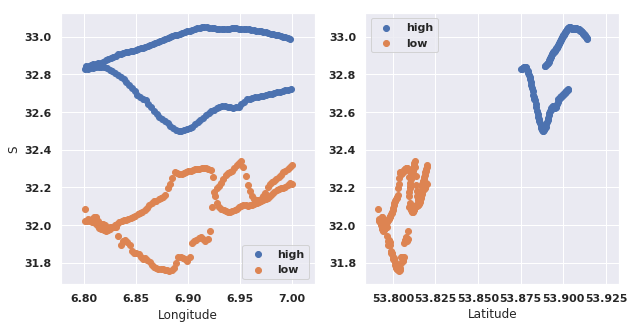

In [36]:
plotsmonthtide(april_south)

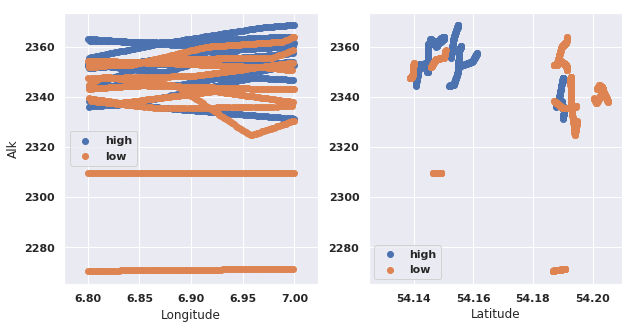

In [37]:
plotalkmonthtide(may_north)

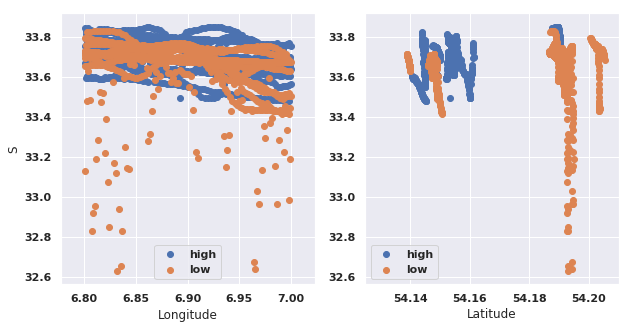

In [38]:
plotsmonthtide(may_north)

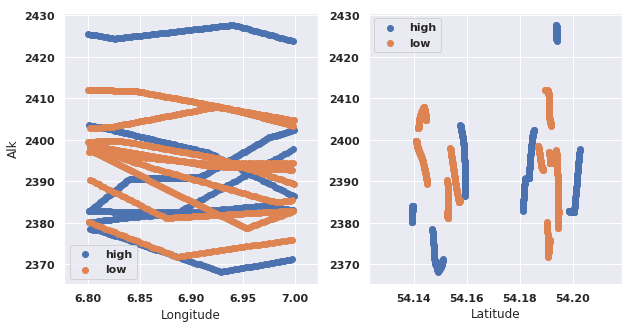

In [39]:
plotalkmonthtide(august_north)

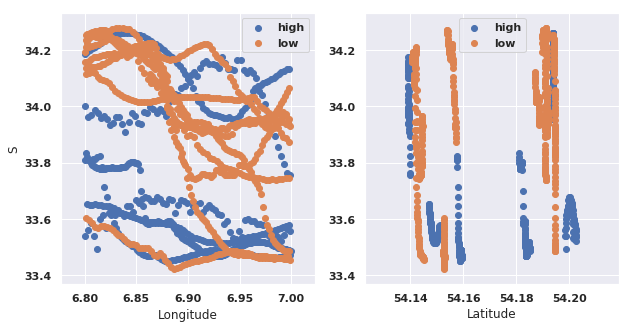

In [40]:
plotsmonthtide(august_north)

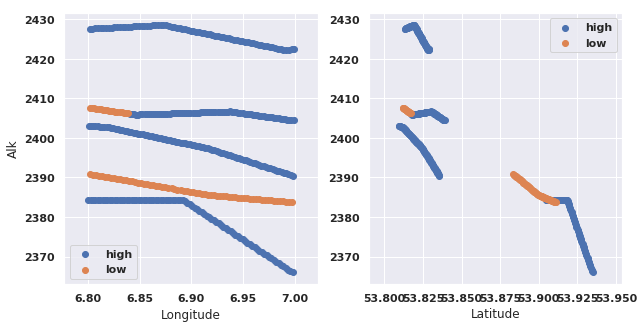

In [41]:
plotalkmonthtide(august_south)

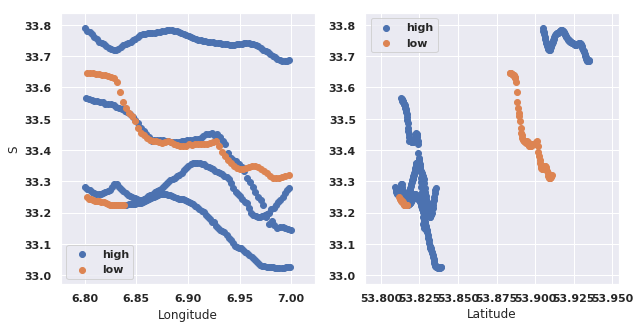

In [42]:
plotsmonthtide(august_south)